In [20]:
import os
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# folders
DATA_DIR   = "data"
OUT_DIR    = "outputs"
CHART_DIR  = "charts"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(CHART_DIR, exist_ok=True)

SYMBOL_YF  = "RELIANCE.NS"
START = "2023-01-01"
END   = date.today().isoformat()

In [22]:
import yfinance as yf

df = yf.download(SYMBOL_YF, start=START, end=END, interval="1d")
df = df.reset_index()  # Date becomes a column
df = df[["Date","Open","High","Low","Close","Volume"]]
df.to_csv(f"{DATA_DIR}/raw_reliance.csv", index=False)
df.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_5832\169882411.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(SYMBOL_YF, start=START, end=END, interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Date,Open,High,Low,Close,Volume
Ticker,,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
0,2023-01-02,1164.066352,1177.304802,1163.244669,1175.889648,5316175
1,2023-01-03,1170.936659,1174.565828,1163.062148,1167.284668,7658932
2,2023-01-04,1167.261851,1169.110728,1147.632506,1149.709595,9264891
3,2023-01-05,1151.969321,1157.858149,1143.067616,1147.655396,13637099
4,2023-01-06,1153.407240,1163.130627,1149.595501,1158.086304,6349597


In [23]:
print(df.columns.tolist())

[('Date', ''), ('Open', 'RELIANCE.NS'), ('High', 'RELIANCE.NS'), ('Low', 'RELIANCE.NS'), ('Close', 'RELIANCE.NS'), ('Volume', 'RELIANCE.NS')]


In [30]:
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").dropna(subset=["Open","Close","Volume"]).reset_index(drop=True)

# features
df["intraday_return_pct"] = (df["Close"] - df["Open"]) / df["Open"] * 100
df["close_return_pct"]    = df["Close"].pct_change() * 100
df["vol_change_pct"]      = df["Volume"].pct_change() * 100

# rolling stats (7d)
df["vol_mean_7"] = df["Volume"].rolling(7, min_periods=3).mean()
df["vol_std_7"]  = df["Volume"].rolling(7, min_periods=3).std()
df["ret_mean_7"] = df["intraday_return_pct"].rolling(7, min_periods=3).mean()
df["ret_std_7"]  = df["intraday_return_pct"].rolling(7, min_periods=3).std()

# z-scores
df["vol_z_7"]   = (df["Volume"] - df["vol_mean_7"]) / df["vol_std_7"].replace(0, np.nan)
df["price_z_7"] = (df["intraday_return_pct"] - df["ret_mean_7"]) / df["ret_std_7"].replace(0, np.nan)

df.to_csv(f"{DATA_DIR}/clean_reliance_with_features.csv", index=False)
df.tail(3)

,Date,Open,High,Low,Close,Volume,intraday_return_pct,close_return_pct,vol_change_pct,vol_mean_7,vol_std_7,ret_mean_7,ret_std_7,vol_z_7,price_z_7,anomaly_statistical,anomaly_absolute,anomaly_any
643,2025-08-11,1364.550161,1382.478557,1355.785119,1380.685669,9997486,1.182478,1.345224,13.690402,8.650296e+06,1.835907e+06,0.060827,1.034975,0.733801,1.083747,False,False,False
644,2025-08-12,1376.402846,1396.323287,1369.729426,1374.908813,12244664,-0.108546,-0.418405,22.477431,8.925081e+06,2.229441e+06,-0.024722,1.018173,1.488976,-0.082328,False,False,False
645,2025-08-13,1382.478519,1386.263451,1372.020288,1377.099976,7457021,-0.389051,0.159368,-39.099832,9.088538e+06,2.039882e+06,-0.248235,0.872013,-0.799810,-0.161483,False,False,False


In [31]:
df["anomaly_statistical"] = (df["vol_z_7"] >= 2) & (df["price_z_7"].abs() >= 2)
df["anomaly_absolute"]    = (df["Volume"] > df["vol_mean_7"] + 2*df["vol_std_7"]) & (df["intraday_return_pct"].abs() >= 5)
df["anomaly_any"]         = df[["anomaly_statistical","anomaly_absolute"]].any(axis=1)

anomalies = df[df["anomaly_any"]].copy()
cols = ["Date","Open","High","Low","Close","Volume",
        "intraday_return_pct","close_return_pct","vol_change_pct",
        "vol_z_7","price_z_7","anomaly_statistical","anomaly_absolute"]
anomalies = anomalies[cols].sort_values("Date")
anomalies.to_csv(f"{OUT_DIR}/anomalies.csv", index=False)
anomalies.tail(10)

,Date,Open,High,Low,Close,Volume,intraday_return_pct,close_return_pct,vol_change_pct,vol_z_7,price_z_7,anomaly_statistical,anomaly_absolute


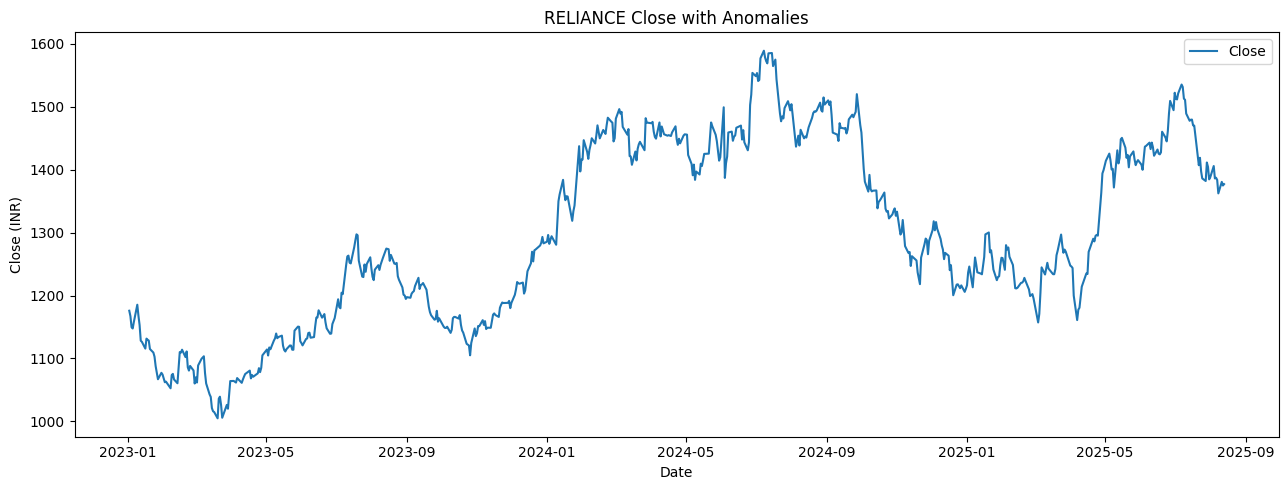

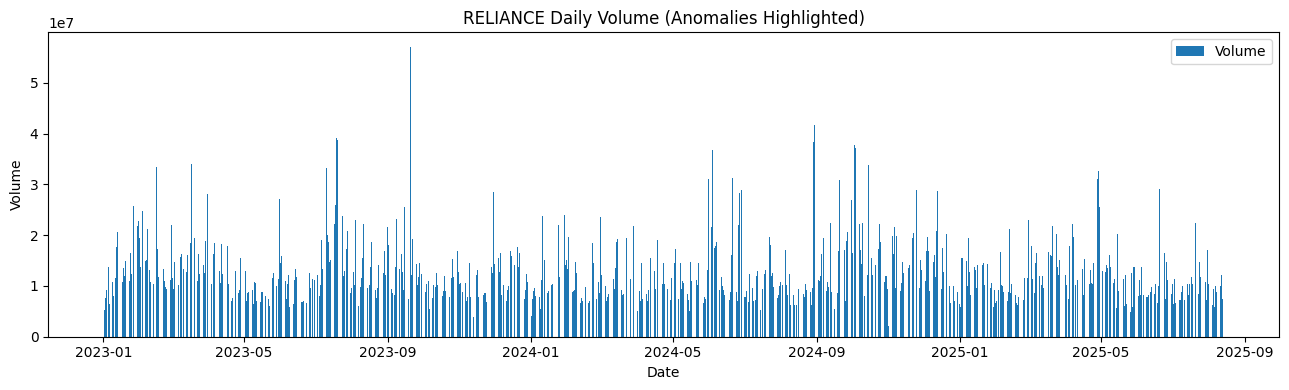

In [32]:
# price with anomaly markers
plt.figure(figsize=(13,5))
plt.plot(df["Date"], df["Close"], label="Close")
if not anomalies.empty:
    plt.scatter(anomalies["Date"], anomalies["Close"], label="Anomaly", zorder=5)
plt.title("RELIANCE Close with Anomalies")
plt.xlabel("Date"); plt.ylabel("Close (INR)")
plt.legend(); plt.tight_layout()
plt.savefig(f"{CHART_DIR}/price_anomalies.png", dpi=150)
plt.show()

# volume with anomaly overlay
plt.figure(figsize=(13,4))
plt.bar(df["Date"], df["Volume"], label="Volume")
if not anomalies.empty:
    plt.bar(anomalies["Date"], anomalies["Volume"], label="Anomaly Volume")
plt.title("RELIANCE Daily Volume (Anomalies Highlighted)")
plt.xlabel("Date"); plt.ylabel("Volume")
plt.legend(); plt.tight_layout()
plt.savefig(f"{CHART_DIR}/volume_anomalies.png", dpi=150)
plt.show()

In [36]:
print(f"Total anomaly days: {anomalies.shape[0]}")
if anomalies.shape[0] > 0:
    display(anomalies.tail(5))

Total anomaly days: 0
